<a href="https://colab.research.google.com/github/Jumikosz/spark/blob/main/ML_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho de ML com Spark | Regressão logística

## Objetivo
O objetivo deste trabalho é utilizar Spark e técnica de classificação, com foco na regressão logística, para desenvolver um modelo preditivo que avalie a probabilidade de um cliente cancelar (churn) ou permanecer ativo em um determinado serviço ou produto.

Instalação do PySpark no notebook, criando sessão e conexão com o Google Drive

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=f7377682cbacf0829960a04a0791a7fe46cbea14f3c879ee9141f5caf2458b74
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("ml_churn_pos").getOrCreate()

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [38]:
df_churn = spark.read.csv(path="/content/drive/MyDrive/Datasets/dataset_churn_cliente.csv", \
                          header=True, \
                          inferSchema=True)

Exibindo o Dataset e removendo o campo ID_CLIENTE, pois ele não será necessário

In [59]:
df_churn = df_churn.drop("ID_CLIENTE")
df_churn.show(5, truncate = False)


+------+------+-------+-----+--------------------+-------+--------+-------+---------+--------+-------+--------------------+------------------+-----+-----------+
|ESTADO|GENERO|DEVICE |IDADE|TRANSACOES_DISTINTAS|FATBRUT|MEUSALDO|VOUCHER|PROD_DIST|RECENCIA|DURACAO|DIAS_DIST_COM_COMPRA|FREQUENCIA_COMPRA |CHURN|CHURN_INDEX|
+------+------+-------+-----+--------------------+-------+--------+-------+---------+--------+-------+--------------------+------------------+-----+-----------+
|PR    |M     |ANDROID|30.0 |91                  |2136.04|0.0     |0.0    |94       |17      |1324   |88                  |15.022988505747126|1    |0.0        |
|PR    |M     |ANDROID|39.0 |50                  |615.29 |0.0     |0.0    |39       |34      |1288   |47                  |27.26086956521739 |1    |0.0        |
|PR    |F     |ANDROID|32.0 |15                  |183.03 |0.0     |0.0    |21       |313     |1242   |13                  |77.41666666666667 |1    |0.0        |
|PR    |M     |IOS    |69.0 |16   

# Esquema:
- ID_CLIENTE = Identificador do cliente
- ESTADO = Estado em que o cliente vive (Ex. Paraná)
- GENERO = Genêro do cliente
- DEVICE  = Qual é o sistema do celular do cliente
- IDADE = Idade do cliente
- TRANSACOES_DISTINTAS = Quantidades de transações (compras) que o cliente já fez
- FATBRUT = Qual o valor total gasto no aplicativo
- MEUSALDO = Valor de saldo em carteira no aplicativo
- VOUCHER = valor de voucher
- PROD_DIST = Quantidade de produtos distintos que já comprou
- RECENCIA = Distância de dias da última compra
- DURACAO = Tempo no aplicativo
- DIAS_DIST_COM_COMPRA = Dias distintos com compra
- FREQUENCIA_COMPRA  = Frequência de compra, média de dias
- CHURN  = variável que assume valores 0 (se o cliente deu churn) e 1 se não



In [60]:
df_churn.printSchema()

root
 |-- ESTADO: string (nullable = true)
 |-- GENERO: string (nullable = true)
 |-- DEVICE: string (nullable = true)
 |-- IDADE: double (nullable = true)
 |-- TRANSACOES_DISTINTAS: integer (nullable = true)
 |-- FATBRUT: double (nullable = true)
 |-- MEUSALDO: double (nullable = true)
 |-- VOUCHER: double (nullable = true)
 |-- PROD_DIST: integer (nullable = true)
 |-- RECENCIA: integer (nullable = true)
 |-- DURACAO: integer (nullable = true)
 |-- DIAS_DIST_COM_COMPRA: integer (nullable = true)
 |-- FREQUENCIA_COMPRA: double (nullable = true)
 |-- CHURN: integer (nullable = true)
 |-- CHURN_INDEX: double (nullable = false)



Importando os pacotes para trabalhar com vetores

In [40]:
from pyspark.ml.feature import VectorAssembler, StringIndexer

Transformação de atributos categóricos: Criando a coluna **CHURN_INDEX**

In [41]:
churn_index = StringIndexer(inputCol="CHURN", outputCol="CHURN_INDEX")
model_label = churn_index.fit(df_churn)
df_churn = model_label.transform(df_churn)

In [42]:
df_churn.show()

+----------+------+------+-------+-----+--------------------+-------+--------+-------+---------+--------+-------+--------------------+------------------+-----+-----------+
|ID_CLIENTE|ESTADO|GENERO| DEVICE|IDADE|TRANSACOES_DISTINTAS|FATBRUT|MEUSALDO|VOUCHER|PROD_DIST|RECENCIA|DURACAO|DIAS_DIST_COM_COMPRA| FREQUENCIA_COMPRA|CHURN|CHURN_INDEX|
+----------+------+------+-------+-----+--------------------+-------+--------+-------+---------+--------+-------+--------------------+------------------+-----+-----------+
|       476|    PR|     M|ANDROID| 30.0|                  91|2136.04|     0.0|    0.0|       94|      17|   1324|                  88|15.022988505747126|    1|        0.0|
|       480|    PR|     M|ANDROID| 39.0|                  50| 615.29|     0.0|    0.0|       39|      34|   1288|                  47| 27.26086956521739|    1|        0.0|
|       482|    PR|     F|ANDROID| 32.0|                  15| 183.03|     0.0|    0.0|       21|     313|   1242|                  13| 77.41

Criando o vetor das features utilizando **VectorAssembler**

In [43]:
df_assembler = VectorAssembler(inputCols=[
                                          "TRANSACOES_DISTINTAS",
                                          "FATBRUT",
                                          "MEUSALDO",
                                          "VOUCHER",
                                          "PROD_DIST",
                                          "RECENCIA",
                                          "DURACAO",
                                          "DIAS_DIST_COM_COMPRA",
                                          "FREQUENCIA_COMPRA"]
                               ,outputCol="features")

df_features = df_assembler.transform(df_churn)


Verificando se o vetor foi criado corretamente

In [44]:
df_features.select(df_features.features).show(20, False)

+----------------------------------------------------------------+
|features                                                        |
+----------------------------------------------------------------+
|[91.0,2136.04,0.0,0.0,94.0,17.0,1324.0,88.0,15.022988505747126] |
|[50.0,615.29,0.0,0.0,39.0,34.0,1288.0,47.0,27.26086956521739]   |
|[15.0,183.03,0.0,0.0,21.0,313.0,1242.0,13.0,77.41666666666667]  |
|[16.0,518.63,0.0,0.0,21.0,324.0,506.0,12.0,16.545454545454547]  |
|[101.0,1292.49,0.0,0.0,80.0,932.0,1326.0,94.0,4.236559139784946]|
|[38.0,1321.37,0.0,0.0,57.0,288.0,1334.0,34.0,31.696969696969695]|
|[10.0,170.29,0.0,0.0,12.0,778.0,1213.0,10.0,48.333333333333336] |
|[3.0,53.24,0.0,0.0,4.0,724.0,933.0,3.0,104.5]                   |
|[20.0,331.54,0.0,0.0,36.0,624.0,1331.0,20.0,37.21052631578947]  |
|[99.0,1507.93,0.0,0.0,95.0,245.0,1333.0,92.0,11.956043956043956]|
|[61.0,972.03,0.0,0.0,66.0,416.0,1332.0,50.0,18.693877551020407] |
|[38.0,780.35,0.0,0.0,54.0,9.0,1318.0,34.0,39.666666666666664]

Definindo a variável **CHURN** (a qual vai ser feita a predição) como **label**

In [45]:
df_churn_final = df_features.withColumnRenamed("CHURN_INDEX", "label")
df_churn_final = df_churn_final.select("label", "features")
df_churn_final.show(20, truncate = False)

+-----+----------------------------------------------------------------+
|label|features                                                        |
+-----+----------------------------------------------------------------+
|0.0  |[91.0,2136.04,0.0,0.0,94.0,17.0,1324.0,88.0,15.022988505747126] |
|0.0  |[50.0,615.29,0.0,0.0,39.0,34.0,1288.0,47.0,27.26086956521739]   |
|0.0  |[15.0,183.03,0.0,0.0,21.0,313.0,1242.0,13.0,77.41666666666667]  |
|0.0  |[16.0,518.63,0.0,0.0,21.0,324.0,506.0,12.0,16.545454545454547]  |
|0.0  |[101.0,1292.49,0.0,0.0,80.0,932.0,1326.0,94.0,4.236559139784946]|
|0.0  |[38.0,1321.37,0.0,0.0,57.0,288.0,1334.0,34.0,31.696969696969695]|
|0.0  |[10.0,170.29,0.0,0.0,12.0,778.0,1213.0,10.0,48.333333333333336] |
|0.0  |[3.0,53.24,0.0,0.0,4.0,724.0,933.0,3.0,104.5]                   |
|0.0  |[20.0,331.54,0.0,0.0,36.0,624.0,1331.0,20.0,37.21052631578947]  |
|0.0  |[99.0,1507.93,0.0,0.0,95.0,245.0,1333.0,92.0,11.956043956043956]|
|0.0  |[61.0,972.03,0.0,0.0,66.0,416.0,1332.0,50.0,

Usando *randomSplit* para separar o dataset em dois, um será usado para treinamento e o outro para validação dos resultados

In [46]:
(trainingData, testData) = df_churn_final.randomSplit([0.7, 0.3])
print(trainingData.count(), testData.count())

288725 123677


In [47]:
trainingData.show(5)
testData.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[1.0,0.97,0.0,0.0...|
|  0.0|[1.0,0.99,0.0,0.0...|
|  0.0|[1.0,1.0,0.0,0.0,...|
|  0.0|[1.0,1.16,0.0,0.0...|
|  0.0|[1.0,1.2,0.0,0.0,...|
+-----+--------------------+
only showing top 5 rows

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[1.0,0.09,0.0,0.0...|
|  0.0|[1.0,0.98,0.0,0.0...|
|  0.0|[1.0,1.13,0.0,0.0...|
|  0.0|[1.0,1.29,0.0,0.0...|
|  0.0|[1.0,1.39,0.0,0.0...|
+-----+--------------------+
only showing top 5 rows



Importando pacotes para um modelo de Regressão Logística

In [48]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [49]:
rl = LogisticRegression()

Treinamento de um modelo de Regressão Logística

In [50]:
rl_modelo = rl.fit(trainingData)

Resultados do modelo:

In [51]:
resultado =rl_modelo.summary
print(resultado.accuracy)
print(resultado.truePositiveRateByLabel)
print(resultado.falsePositiveRateByLabel)
print(resultado.precisionByLabel)
print(resultado.recallByLabel)

0.9764031517880336
[0.9796015250641624, 0.9689262924257838]
[0.031073707574216222, 0.020398474935837525]
[0.9866124790819986, 0.953093551358297]
[0.9796015250641624, 0.9689262924257838]


In [52]:
print(f"Taxa de Verdadeiros Positivos: {resultado.truePositiveRateByLabel[1] * 100} %")
print(f"Taxa de Falsos Positivos: {resultado.falsePositiveRateByLabel[1] * 100} %")
print(f"Precisão: {resultado.precisionByLabel[1] * 100} %")
print(f"Recall: {resultado.recallByLabel[1] *100} %")
print(f"Acurácia: {resultado.accuracy * 100} %")

Taxa de Verdadeiros Positivos: 96.89262924257838 %
Taxa de Falsos Positivos: 2.0398474935837525 %
Precisão: 95.3093551358297 %
Recall: 96.89262924257838 %
Acurácia: 97.64031517880336 %


In [53]:
df_resultado = rl_modelo.transform(testData)
df_resultado.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|[1.0,0.09,0.0,0.0...|[2.31548408117528...|[0.91015133077346...|       0.0|
|  0.0|[1.0,0.98,0.0,0.0...|[173.751271979794...|           [1.0,0.0]|       0.0|
|  0.0|[1.0,1.13,0.0,0.0...|[29.2457794237516...|[0.99999999999980...|       0.0|
|  0.0|[1.0,1.29,0.0,0.0...|[259.797622017221...|           [1.0,0.0]|       0.0|
|  0.0|[1.0,1.39,0.0,0.0...|[143.864811611921...|           [1.0,0.0]|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



Visualizando a matriz de confusão

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = df_resultado.select(['label']).collect()
y_pred = df_resultado.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     86790
         1.0       0.95      0.97      0.96     36887

    accuracy                           0.98    123677
   macro avg       0.97      0.97      0.97    123677
weighted avg       0.98      0.98      0.98    123677



Gráfico de curva ROC (é uma representação gráfica que ilustra o desempenho de um sistema classificador binário à medida que o seu limiar de discriminação varia)

In [55]:
evaluator = BinaryClassificationEvaluator()
roc = evaluator.evaluate(df_resultado)
print(roc)

0.9976791192145998


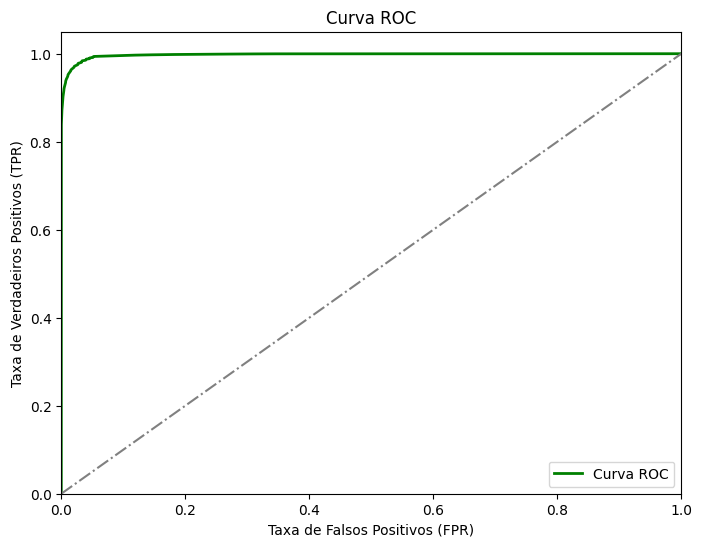

In [56]:
import matplotlib.pyplot as plt
import numpy as np

resultado = rl_modelo.summary
fpr = resultado.roc.toPandas()['FPR']
tpr = resultado.roc.toPandas()['TPR']

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='green', lw=2, label='Curva ROC')
plt.plot([0, 1], [0, 1], color='gray', linestyle='-.')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Previsões erradas e corretas e matriz de confusão em quantidade

In [57]:
correct_predictions = df_resultado.filter(df_resultado["label"] == df_resultado["prediction"]).count()
incorrect_predictions = df_resultado.filter(df_resultado["label"] != df_resultado["prediction"]).count()

print(f"Previsões corretas: {correct_predictions}")
print(f"Previsões incorretas: {incorrect_predictions}")
confusion_matrix = df_resultado.crosstab("label", "prediction")
confusion_matrix.show()


Previsões corretas: 120778
Previsões incorretas: 2899
+----------------+-----+-----+
|label_prediction|  0.0|  1.0|
+----------------+-----+-----+
|             1.0| 1126|35761|
|             0.0|85017| 1773|
+----------------+-----+-----+



## Sugestões de melhoria:

Afim de melhorar o trabalho e os resultados apresentados gostaria de utilizar outros algoritmos de ML para avaliar qual apresentaria o melhor resultado, como por exemplo árvores de decisão, fazer o tratamento de desequilíbro de classes usando oversampling ou técnica similar.
Além disso, gostaria de avaliar os resultados em outras bases de teste e plotar mais gráficos, como por exemplo o de matrix de correlação para entender melhor o comportamento das variáveis.
